# F10.7 From Pretrained Embeddings

## Background
This notebook is intended to be a quick example of the information contained within the SDO-FM embeddings. There is limited scientific value in this prediction of a proxy measure such as F10.7, however the conclusion of this notebook clearly indicates learned capacity in one plot.

It was suggested at an early scientific-community meeting that it would also be interested to see how the image embeddings of our SDO-trained foundation model might compare with a generally-trained Google image foundation model. Their model is available over an easy-to-use API to all those with a billable Google Cloud Project, however only accepts conventional images as png/jpeg/etc. Hence, three months (2015-02-01 to 2015-05-31, known as the "St Patrick's Day Storm") of daily SDOML was converted into PNGs via code included here in the appendix. These were then uploaded with a request for maximum embedding size and have been provided here for your analysis.

## Process
The plan here is to take SDO-FM and Google Embeddings and train a very simple model to predict F10.7 with them as input. This involves:
 1. *(optional)* Collecting the embeddings - these have been collected and pickled for convenice
 2. *(optional)* Aligning and placing them into a format approporiate for training
 3. Define the model and data loader
 4. Model training
 5. Visualization for comparison 

The first two steps (and appendix) result in a set of pickled files with these embeddings available. They're included here to explain their provenance (and for tinkering!)

## (optional) Collecting Embeddings
First, collect the available times in this embedding dataset.

In [ ]:
import h5py

filename = "sdo_latent_dataset_21504.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys)
    # these can be group or dataset names
    print("Keys: %s" % f.keys())
    print(f["latent"][0].shape)
    day, hour, minute, month, year = (
        list(f["day"]),
        list(f["hour"]),
        list(f["minute"]),
        list(f["month"]),
        list(f["year"]),
    )

Keys: <KeysViewHDF5 ['day', 'hour', 'latent', 'minute', 'month', 'year']>
(21504,)


From these collected times, load those we're interested in training with. Here we'll collect three years of hourly data at 12 mins past the hour.

In [ ]:
useful = {}
for i in range(len(day)):
    # Time format is given as 2015-04-30_00:12:00-193
    # if year[i] == 2015 and month[i] in [3,4] and minute[i] == 12: #and hour[i] == 0 and
    if year[i] in [2013, 2014, 2015] and minute[i] == 12:  # and hour[i] == 0 and
        useful[
            f"{year[i]}-{month[i]:02d}-{day[i]:02d}_{hour[i]:02d}:{minute[i]:02d}:00"
        ] = i

Now collect the embeddings for these times.

In [ ]:
with h5py.File(filename, "r") as f:
    embeddings = f["latent"][list(useful.values())]

## (optional) Aligning Embeddings and Preparing for Model Consumption

Quickly define some helper functions so we can persist variables.

In [ ]:
import dill as pickle


def pickle_dict(dict, name):
    with open(f"{name}.pkl", "wb") as file:
        pickle.dump(dict, file)


def unpickle_dict(name):
    with open(f"{name}.pkl", "rb") as file:
        return pickle.load(file)

In [24]:
expensive_results = unpickle_dict("google_embeddings")

Set up these data ready for training

In [ ]:
import numpy as np
import pandas as pd

# There were some dates missing from this embeddings dataset, explictly define dates
overlap = [
    "2015-03-01",
    "2015-03-02",
    "2015-03-06",
    "2015-03-07",
    "2015-03-09",
    "2015-03-10",
    "2015-03-11",
    "2015-03-12",
    "2015-03-13",
    "2015-03-14",
    "2015-03-16",
    "2015-03-18",
    "2015-03-19",
    "2015-03-20",
    "2015-03-21",
    "2015-03-22",
    "2015-03-23",
    "2015-03-25",
    "2015-03-26",
    "2015-03-27",
    "2015-03-28",
    "2015-03-29",
    "2015-03-30",
    "2015-04-01",
    "2015-04-03",
    "2015-04-04",
    "2015-04-05",
    "2015-04-06",
    "2015-04-07",
    "2015-04-08",
    "2015-04-10",
    "2015-04-11",
    "2015-04-12",
    "2015-04-13",
    "2015-04-14",
    "2015-04-15",
    "2015-04-16",
    "2015-04-17",
    "2015-04-18",
    "2015-04-19",
    "2015-04-21",
    "2015-04-22",
    "2015-04-23",
    "2015-04-24",
    "2015-04-25",
    "2015-04-26",
    "2015-04-27",
    "2015-04-28",
    "2015-04-29",
    "2015-04-30",
]  # '2015-03-31', '2015-03-24',

Collect the F10.7 targets

In [162]:
f107 = pd.read_csv("f10.7.csv")
f107 = (
    f107.reset_index()
    .set_index(pd.to_datetime(f107["date"], format="%Y%m%d").dt.strftime("%Y-%m-%d"))
    .drop(columns=["index", "date"])
    .to_dict()[" f107"]
)
f107 = {k: float(v) for k, v in f107.items()}  # if k in overlap}
f107 = dict(sorted(f107.items()))

pickle_dict(f107, "f107")

Create the Google embeddings 

In [ ]:
google_embeddings_dataloader_ready = {}

# for k, v in expensive_results.items():
#     ts = k.split('_')[0]
#     ts = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]}"
#     if ts in overlap:
#         google_embeddings_dataloader_ready[ts] = np.hstack(v).astype(np.float64)

google_latents_dataloader_ready = {}
moar_google = unpickle_dict("google_embeddings_moar")
f107_for_daily_google = []

for k, v in moar_google.items():
    ts = k.split("_")[0]
    ts = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]}"
    if ts in f107 and np.all(np.hstack(v) != None):
        google_latents_dataloader_ready[k] = np.hstack(v).astype(np.float64)
        f107_for_daily_google.append(f107[ts])

pickle_dict(
    google_embeddings_dataloader_ready, "google_embeddings_dataloader_ready_matched"
)

Create the SDO-FM NVAE embeddings

In [155]:
nvae_embeddings_dataloader_ready = {}
for i, k in enumerate(useful.keys()):
    ts = k  # .split('_')
    # if ts in overlap:
    nvae_embeddings_dataloader_ready[ts] = embeddings[i, :].astype(np.float64)

nvae_embeddings_dataloader_ready = dict(
    sorted(nvae_embeddings_dataloader_ready.items())
)
# pickle_dict(nvae_embeddings_dataloader_ready, 'nvae_latents_dataloader_ready')

f107_for_daily_nvae = []
nvae_embeddings_dataloader_ready_matched = {}
for k, v in nvae_embeddings_dataloader_ready.items():
    date = k.split("_")[0]
    if date in f107:
        f107_for_daily_nvae.append(f107[date])
        nvae_embeddings_dataloader_ready_matched[k] = v

pickle_dict(
    nvae_embeddings_dataloader_ready_matched, "nvae_embeddings_dataloader_ready_matched"
)

## Model construction (start here if not beginning from scratch)
Quickly define some helper functions so we can persist variables.

In [ ]:
import dill as pickle


def pickle_dict(dict, name):
    with open(f"{name}.pkl", "wb") as file:
        pickle.dump(dict, file)


def unpickle_dict(name):
    with open(f"{name}.pkl", "rb") as file:
        return pickle.load(file)

In [6]:
import dill as pickle

google_embeddings_dataloader_ready_matched = unpickle_dict(
    "google_embeddings_dataloader_ready_matched"
)
nvae_embeddings_dataloader_ready_matched = unpickle_dict(
    "nvae_embeddings_dataloader_ready_matched"
)
f107 = unpickle_dict("f107")

In [216]:
len(f107), len(google_embeddings_dataloader_ready_matched), len(
    nvae_embeddings_dataloader_ready_matched
)

(15682, 50, 21808)

Define a small module for processing a (embedding, target F10.7) item. 

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn

from torchmetrics import Accuracy

torch.set_default_dtype(torch.float64)

# Define train/test/val split
# The test set will be constructed with the remaining percentage (1 - PROPORTION_TRAIN - PROPORTION_VAL)*100%
PROPORTION_TRAIN = 0.67  # 2/3 of data
PROPORTION_VAL = 0.1  # 1/10 of data


class EmbSolarProxyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class EmbSolarProxyDataModule(pl.LightningDataModule):
    def __init__(self, emb, tar):
        super().__init__()

        self.data = []
        for i, t in enumerate(emb.items()):
            k, v = t
            self.data.append((k, v, tar[i]))
        self.batch_size = 1
        self.num_workers = 16

        n = len(self.data)
        seed = 0
        torch.manual_seed(seed)
        train_size = int(PROPORTION_TRAIN * n)
        val_size = int(PROPORTION_VAL * n)
        test_size = n - train_size - val_size

        self.train_data = self.data[train_size:]
        self.val_data = []
        self.test_data = self.data[: (n - train_size)]

        self.train_ds = EmbSolarProxyDataset(self.train_data)
        self.val_ds = EmbSolarProxyDataset(self.val_data)
        self.test_ds = EmbSolarProxyDataset(self.test_data)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers
        )

Create a very simple MLP model

In [168]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        output_dim=1,
        hidden_layer_dims=[256, 256, 256],
        dropout=0.0,
        act=nn.LeakyReLU(negative_slope=0.01),
    ):
        super().__init__()

        # Define the dimensions of the MLP layers
        dims = [input_dim] + hidden_layer_dims

        # Define the dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Define the fully connected layers
        self.fcs = nn.ModuleList(
            [nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)]
        )

        # Define the activation function
        self.act = act
        self.acts = nn.ModuleList([self.act for _ in range(len(dims) - 1)])

        # Define the output layer
        self.fc_out = nn.Linear(dims[-1], output_dim)

        # Define the loss function
        self.criterion = nn.MSELoss()

        # Initialize a dictionary to store test predictions
        self.test_preds = {}

    def forward(self, x):
        # Forward pass through the MLP
        for fc, act in zip(self.fcs, self.acts):
            d = self.dropout(x)
            z = fc(d)
            x = act(z)
        return self.fc_out(x)

    def training_step(self, batch, batch_idx):
        # Training step
        _, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step
        _, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Test step
        ts, x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("test_loss", loss, prog_bar=True)
        self.test_preds[ts] = [x, y, logits]
        return loss

    def configure_optimizers(self):
        # Configure the optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

## Training the models
Define the data modules for each embedding dataset

In [167]:
dm_sdofm = EmbSolarProxyDataModule(
    nvae_embeddings_dataloader_ready_matched, f107_for_daily_nvae
)
dm_google = EmbSolarProxyDataModule(
    google_embeddings_dataloader_ready_matched, f107_for_daily_google
)

Create the models

In [ ]:
model_f107_with_sdofm_embeddings = MultiLayerPerceptron(input_dim=21504)
model_f107_with_google_embeddings = MultiLayerPerceptron(input_dim=12672)

Train a model on the SDO-FM embeddings

In [ ]:
import os

os.environ["PJRT_DEVICE"] = "GPU"

# If there is a GPU attached, use it
if torch.cuda.is_available():
    # Devices allow selection of which GPU where mulitple available, precision is floating point accuracy
    trainer_sdofm = pl.Trainer(max_epochs=100, devices=[0], precision=32)
else:
    trainer_sdofm = pl.Trainer(max_epochs=10)

# Begin training
trainer_sdofm.fit(model=model_f107_with_sdofm_embeddings, datamodule=dm_sdofm)

# Save the checkpoint manually (lightning will do this automatically anyway)
trainer_sdofm.save_checkpoint("nvaef107-e=100.ckpt")

Now that we have a model trained, let's use it to predict over the test set. This is done by using the Pytorch Lightning trainer from above in test mode, it should do all the usual torch requirements like freezing grads, etc.

In [171]:
test_results = trainer_sdofm.test(model_f107_with_sdofm_embeddings, datamodule=dm_sdofm)
test_results

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5162.031591234501     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5162.031591234501}]

Train a model on Google Embeddings

In [310]:
import os

os.environ["PJRT_DEVICE"] = "GPU"

# If there is a GPU attached, use it
if torch.cuda.is_available():
    # Devices allow selection of which GPU where mulitple available, precision is floating point accuracy
    trainer_google = pl.Trainer(max_epochs=100, devices=[0], precision=32)
else:
    trainer_google = pl.Trainer(max_epochs=10)

# Begin training
trainer_google.fit(model=model_f107_with_google_embeddings, datamodule=dm_google)

# Save the checkpoint manually (lightning will do this automatically anyway)
trainer_google.save_checkpoint("googlef107-e=100.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | dropout   | Dropout    | 0      | train
1 | fcs       | ModuleList | 3.4 M  | train
2 | act       | LeakyReLU  | 0      | train
3 | acts      | ModuleList | 0      | train
4 | fc_out    | Linear     | 257    | train
5 | criterion | MSELoss    | 0      | train
-------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.505    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:105: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=10` reached.


In [311]:
trainer_google.test(model_f107_with_google_embeddings, datamodule=dm_google)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     447.8582451980212     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 447.8582451980212}]

## Visualization for comparison 

Collect the Google Embeddings model predictions

In [312]:
tp_google = model_f107_with_google_embeddings.test_preds
tp_google = dict(sorted(tp_google.items()))
y_google, preds_google = [], []

for i in tp_google.values():
    y_google.append(i[1].cpu().detach().numpy()[0])
    preds_google.append(i[2].cpu().detach().numpy()[0])

In [314]:
import pandas as pd

# Clean up the date format on the keys
tpg = [pd.to_datetime(i[0], format="%Y%m%d_%H:%M:%S") for i in tp_google.keys()]

Collect the SDOFM model predictions

In [ ]:
tp_nvae = model_f107_with_sdofm_embeddings.test_preds

y_nvae, preds_nvae = [], []
for i in tp_nvae.values():
    y_nvae.append(i[1].cpu().detach().numpy()[0])
    preds_nvae.append(i[2].cpu().detach().numpy()[0])

Produce the full comparison plot

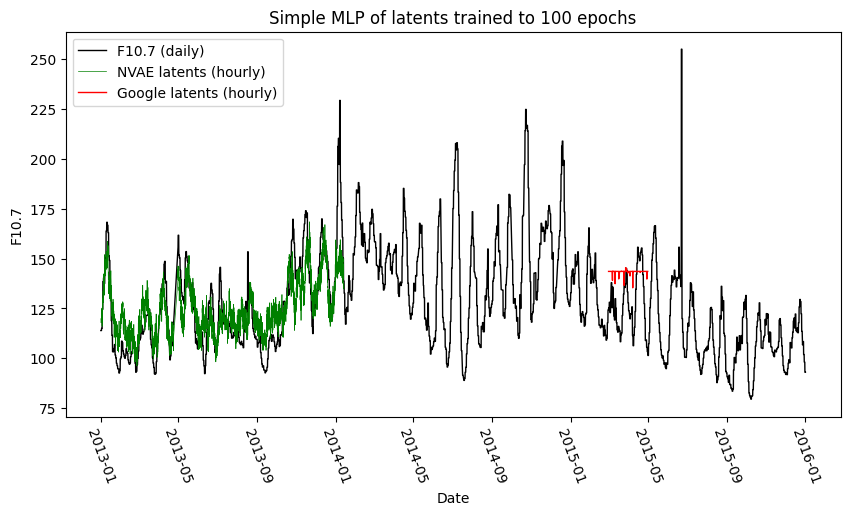

In [315]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
# plt.plot([pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S") for i in nvae_latents_dataloader_ready_matched.keys()], f107_for_daily_nvae, label="F10.7 (daily)")
plt.plot(
    [
        pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S")
        for i in nvae_embeddings_dataloader_ready_matched.keys()
    ],
    f107_for_daily_nvae,
    label="F10.7 (daily)",
    linewidth=1,
    c="black",
)
p_x = [pd.to_datetime(i[0], format="%Y-%m-%d_%H:%M:%S") for i in tp_nvae.keys()]
plt.plot(
    p_x, preds_nvae, label="SDOFM NVAE embeddings (hourly)", linewidth=0.5, c="green"
)
plt.plot(
    tpg,
    np.array(preds_google).reshape(-1),
    label="Google latents (hourly)",
    linewidth=1,
    c="red",
)
plt.legend()
plt.xticks(rotation=290)
plt.ylabel("F10.7")
plt.xlabel("Date")
plt.title("Simple MLP of latents trained to 100 epochs")
# plt.xlim((np.min(p_x), np.max(p_x)))
plt.show()

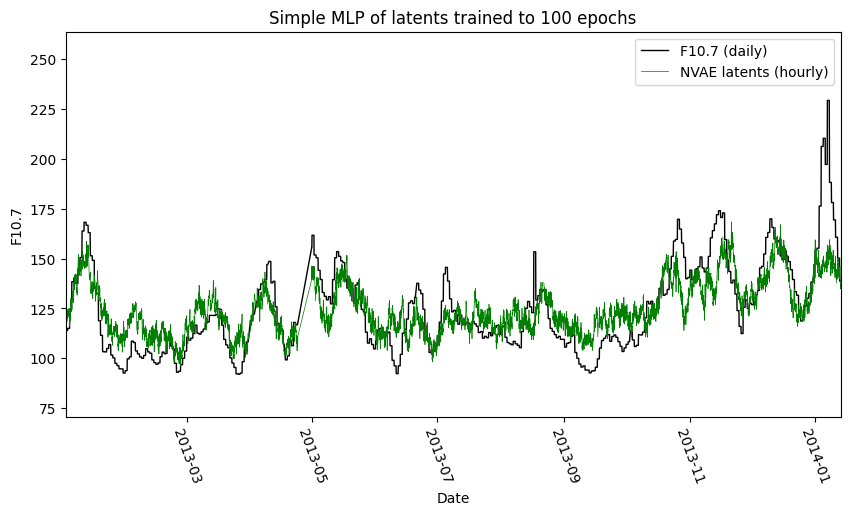

In [207]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(
    [
        pd.to_datetime(i, format="%Y-%m-%d_%H:%M:%S")
        for i in nvae_embeddings_dataloader_ready_matched.keys()
    ],
    f107_for_daily_nvae,
    label="F10.7 (daily)",
    linewidth=1,
    c="black",
)
p_x = [pd.to_datetime(i[0], format="%Y-%m-%d_%H:%M:%S") for i in tp_nvae.keys()]
plt.plot(
    p_x, preds_nvae, label="SDO-FM NVAE latents (hourly)", linewidth=0.5, c="green"
)
plt.legend()
plt.xticks(rotation=290)
plt.ylabel("F10.7")
plt.xlabel("Date")
plt.title("Simple MLP of latents trained to 100 epochs")
plt.xlim((np.min(p_x), np.max(p_x)))
plt.show()

That's all folks! Read on into the appendix to validate the creation of the Google embeddings. Do reach out to us at team@trillium.tech with any feedback!

#### Acknowledgements
This work is the research product of the SDO-FM: A Multi-Modal Foundation Model POC for SDO (Grant#: 80NSSC24K0701); funded and supported by NASA. The research and its outputs have been designed, managed and delivered by Trillium Technologies Inc.

**Authors**

James Walsh, University of Cambridge  
Daniel Gass, University of Central Lancashire  
Raul Ramos Pollan, Universidad Industrial de Santander  
Richard Galvez, Pure Storage  
Paul Wright, Dublin Institute for Advanced Studies  
Atılım Güneş Baydin, University of Oxford  
Noah Kasmanoff, AE Studio   
Jason Naradowsky, University of Tokyo  

PI: Anne Spalding, Trillium Technolgies Inc  
Co-I: James Parr, Trillium Technologies Inc 

# Appendix

## Google Image Embeddings
### Make PNGs from SDOML

In [1]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule
from sdofm.pretraining import SAMAE

In [268]:
import omegaconf
from sdofm.datasets import (
    SDOMLDataModule,
    HelioProjectedSDOMLDataModule,
    NonLinearSDOMLDataModule,
    TimestampedSDOMLDataModule,
)
import os

# Load in an experiment configuration file for a dataloader for SDOML.
# We're only using this to define the dataloader, all the typical
# model code is irrelevant.
cfg_path = "../experiments/for_google_emb.yaml"
cfg = omegaconf.OmegaConf.load(cfg_path)

# Use the TimestampedSDOML loader for optional timestamp verification.
data_module = TimestampedSDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [ ]:
import sunpy.visualization.colormaps as sunpycm
import matplotlib.pyplot as plt

# Collect suitable color maps from sunpy
cms = [
    # sunpycm.cmlist.get("hmimag"),
    # sunpycm.cmlist.get("hmimag"),
    # sunpycm.cmlist.get("hmimag"),
    sunpycm.cmlist.get("sdoaia94"),
    sunpycm.cmlist.get("sdoaia131"),
    sunpycm.cmlist.get("sdoaia171"),
    sunpycm.cmlist.get("sdoaia193"),
    sunpycm.cmlist.get("sdoaia211"),
    sunpycm.cmlist.get("sdoaia304"),
    sunpycm.cmlist.get("sdoaia335"),
    sunpycm.cmlist.get("sdoaia1600"),
    sunpycm.cmlist.get("sdoaia1700"),
]

# List of wavelengths for file names
names = ["94", "131", "171", "193", "211", "304", "335", "1600", "1700"]

# Iterate through our validation dataset which has been set for our St. Patrick's Day storm
# We use the valid (or test) dataset because shuffling is disabled, unlike for training.
for r in iter(data_module.valid_ds):
    imgs, timestamp = r["image_stack"], r["timestamps"][0].replace(" ", "_")
    for i in range(9):
        plt.imsave(
            f"imgs_for_google_emb/{timestamp}-{names[i]}.png",
            imgs["image_stack"][i, 0, :, :],
            cmap=cms[0],
        )

Upload those to a GCP Bucket. This done with the CLI, specifically with `gcloud storage cp imgs_for_google_emb/* gs://sdofm-vertexai-emb-test`, where `sdofm-vertexai-emb-test` is our GCP bucket.

### Send API requests

In [169]:
import requests


# This function returns the API request JSON for submission to Vertex AI with
# our png location and embedding dimension request size.
def make_request(file):
    return {
        "instances": [
            {
                "image": {
                    "gcsUri": f"gs://sdofm-vertexai-emb-test/{file}.png",
                },
            },
        ],
        "parameters": {"dimension": 1408},
    }

In [177]:
import glob
from time import sleep
import dill as pickle
import numpy as np
import requests
import subprocess

# Collect all our PNGs
files = glob.glob("imgs_for_google_emb/*.png")

# Index to store each wavelength in a seperate array element
wav_map = {
    "94": 0,
    "131": 1,
    "171": 2,
    "193": 3,
    "211": 4,
    "304": 5,
    "335": 6,
    "1600": 7,
    "1700": 8,
}

# A dictionary to store our requests, marked as such because these
# cost money in API calls!
expensive_results = {}

c = 0
for i, f in enumerate(files):
    # We only look at imagery once per day, at 12 minutes past midnight
    if ":12:00" in f:
        c += 1

        # Determine wavelength and timestamp for file
        part = f.replace("imgs_for_google_emb/", "").replace(".png", "")
        wav = part.split("-")[-1]
        ts = "".join(part.split("-")[:-1])

        # If we haven't seen this timestamp before, alloc an empty list for storage
        if ts not in expensive_results:
            expensive_results[ts] = [None] * 9

        # Pull our access token from CLI, this rotates fairly rapidly
        auth = (
            subprocess.run(
                "gcloud auth print-access-token".split(" "), stdout=subprocess.PIPE
            )
            .stdout.decode("utf-8")
            .replace("\n", "")
        )

        # If we don't already have this result, send request for image processing
        if expensive_results[ts][wav_map[wav]] is None:
            r = requests.post(
                "https://us-central1-aiplatform.googleapis.com/v1/projects/sdo-fm-2024/locations/us-central1/publishers/google/models/multimodalembedding@001:predict",
                headers={
                    "Authorization": f"Bearer {auth}",
                    "Content-Type": "application/json; charset=utf-8",
                },
                json=make_request(part),
            )

            # If successful, store result in list
            if r.status_code == 200:
                expensive_results[ts][wav_map[wav]] = np.array(
                    r.json()["predictions"][0]["imageEmbedding"]
                )
            else:
                print("Error on", part)

        # Progress tracking and checkpointing the dict
        if c % 40 == 0:
            print(f"{c} completed which is {100*(i/len(files)):02f}% completed")
            with open("google_embeddings_moar.pkl", "wb") as file:
                pickle.dump(expensive_results, file)

        # The API docs suggest there's a throttle at 2 requests per second, so pause for half a sec
        sleep(0.5)
print("Complete")

40 completed which is 0.003306% completed
80 completed which is 0.007111% completed
120 completed which is 0.010564% completed
160 completed which is 0.014646% completed
200 completed which is 0.018654% completed
240 completed which is 0.023050% completed
280 completed which is 0.026928% completed
320 completed which is 0.031342% completed
360 completed which is 0.035941% completed
400 completed which is 0.039709% completed
440 completed which is 0.044031% completed
480 completed which is 0.047688% completed
520 completed which is 0.051732% completed
560 completed which is 0.054835% completed
600 completed which is 0.058437% completed
640 completed which is 0.062463% completed
680 completed which is 0.065972% completed
720 completed which is 0.069315% completed
760 completed which is 0.072787% completed
800 completed which is 0.077054% completed
840 completed which is 0.080323% completed
880 completed which is 0.083223% completed
920 completed which is 0.087378% completed
960 completed

The embeddings have now been retrieved for our small subset and pickled into a local file. These are now ready for model training.

In [167]:
pickle_dict(expensive_results, "more_expensive_results_hourly")

'imgs_for_google_emb/2015-03-29_01:00:00-171.png'